In [13]:
pip install nilearn

Note: you may need to restart the kernel to use updated packages.


In [14]:
import numpy as np
import nibabel as nib  # For handling NIfTI files
import matplotlib.pyplot as plt  # For plotting images
from nilearn import plotting # For neuroimaging visualization

import os
import glob
from scipy import stats

In [15]:
def download_abide_sample(n_subjects = 25, download_dir = "abide_data"): # default is 25
  '''
  Downloads a sample of healthy (no alzheimers and other things) control fMRI data from ABIDE dataset

  n_subjects: number of subjects to download
  download_dir: directory to download data to

  returns: list of file paths to downloaded data
  '''
  from nilearn.datasets import fetch_abide_pcp

  # Make sure that download directory exists
  os.makedirs(download_dir, exist_ok = True)

  # Fetch ABIDE control (healthy) data

  # abide_data = fetch_abide_pcp(n_subjects = n_subjects,
  #                                 derivatives = ["func_preproc"], # Preprocessed functional data
  #                                 quality_checked = True,  # Only data passing quality checks
  #                                 SUB_ID = None,  # All subjects
  #                                 DX_GROUP = 1,   # 1 = controls, 2 = autism
  #                                 data_dir = download_dir
  # )

  abide_data = fetch_abide_pcp(n_subjects = n_subjects, derivatives = ['func_preproc'], DX_GROUP = 1, data_dir = download_dir)


  # patient_data = fetch_abide_pcp(n_subjects=1, derivatives=['func_preproc'], DX_GROUP=2)
  # patient_fmri = patient_data.func_preproc[0]  # First subject's fMRI data

  # Return paths to fMRI data
  return abide_data.func_preproc


In [16]:
def compute_baseline_stats(fmri_files):
  '''
  Compute mean intensity + std dev for each voxel across multiple healthy brain scans

  fmri_files: List of file paths to fMRI NIfTI files

  Returns NIfTI images containing mean and std dev at each voxel
  '''

  print(f"Computing baseline statistics from {len(fmri_files)} subjects...")

  # Load the first image to get dimensions and affine
  first_img = nib.load(fmri_files[0])
  shape = first_img.shape
  affine = first_img.affine

  # Since we have fMRI data, first, we're going to average across time for each subject
  # Next, we will do the subject averages

  all_subject_means = []

  for i, file_path in enumerate(fmri_files):
    img = nib.load(file_path)
    data = img.get_fdata()

    # If 4D (time series), calculate temporal mean for each voxel
    if len(data.shape) == 4:
        subject_mean = np.mean(data, axis=3)
    else:
      subject_mean = data

    all_subject_means.append(subject_mean)  # contains the functional data of each subject with time averaged out

  # Stack all the subject means into one np array to compute group statistics
  all_means_array = np.stack(all_subject_means, axis=0)

  # Calulate mean and std across the subjects
  group_mean = np.mean(all_means_array, axis=0)
  group_std = np.std(all_means_array, axis=0)

  # Replace the zeros in std to avoid division by zero when calc z-scores
  group_std[group_std < 1e-6] = 1e-6

  # Turn the functional data of each subject back to NIfTI images
  # Create NIfTI images
  mean_img = nib.Nifti1Image(group_mean, affine)
  std_img = nib.Nifti1Image(group_std, affine)

  return mean_img, std_img



In [17]:
def calculate_zscore(patient_fmri, mean_img, std_img):

  '''
  Calculate z-score for each voxel in a patient's fMRI data

  patient_fmri: NIfTI image containing patient's fMRI data
  mean_img: NIfTI image containing mean intensity values across baseline subjects
  std_img: NIfTI image containing std dev values across baseline subjects

  Returns: NIfTI image containing z-scores for each voxel
  '''

  # Load patient data if file path provided
  if isinstance(patient_fmri, str):
      patient_img = nib.load(patient_fmri)
  else:
      patient_img = patient_fmri

  patient_data = patient_img.get_fdata()

  # If 4D (time series), calculate temporal mean
  if len(patient_data.shape) == 4:
      patient_data = np.mean(patient_data, axis=3)

  # Get mean and std data
  mean_data = mean_img.get_fdata()
  std_data = std_img.get_fdata()

  # Calculate z-score: (patient - mean) / std
  z_score_data = (patient_data - mean_data) / std_data

  # Create a new NIfTI image with the z-scores
  z_score_img = nib.Nifti1Image(z_score_data, patient_img.affine)
  
  print("Z-score min/max:", np.min(z_score_data), np.max(z_score_data))

  return z_score_img

In [18]:
def create_intensity_colormap(vmin = -1, vmax = 1):
    '''
    Create colormap for visualizing brain activity intensity
    Blue for underactivity and red for over

    vmin: Min z-score value (max blue)
    vmax: Max z-score value (min red)

    Returns: Colormap for visualization
    '''

    import matplotlib.colors as mcolors

    # Define colors for our colormap
    colors = [
        (0, 0, 0.8),      # Deep blue for extreme underactivity
        (0.4, 0.6, 1),    # Light blue for mild underactivity
        (1, 1, 1),        # White for normal activity
        (1, 0.6, 0.4),    # Light red for mild overactivity
        (0.8, 0, 0)       # Deep red for extreme overactivity
    ]

    # Create colormap
    cmap_name = 'activity_colormap'
    cm = mcolors.LinearSegmentedColormap.from_list(cmap_name, colors, N=256)

    return cm

In [19]:
def plot_brain_activity(z_score_img, output_file = None, threshold = 0.5,
                        colormap = None, display_mode = 'ortho',
                        title = "Brain Activity Z-Scores", vmin = -1, vmax = 1):
    '''
    Plot brain activity z-scores with heatmap visualization

    z_score_img: Image containing z-score data
    output_file: Path to save the plot (optional)
    threshold: Z-score Threshold for displaying
    colormap: colormap to use
    display_mode: Display mode for plotting
    title: Title for the plot

    returns plotting object
    '''

    # # Create a symmetric vmax for the colorbar
    # vmax = max(5, np.percentile(np.abs(z_score_img.get_fdata()), 99))

    # Setting cut_coords based on display_mode.. had some issues with this prior
    if display_mode == "ortho":
        # Use [x,y,z] coordinates for ortho mode
        cut_coords = (0, 0, 0)  # Center of the volume
    else:
        # For single-plane view, 5 slices is good enough
        cut_coords = 5

    # Plot using nilearn's plotting utilities
    display = plotting.plot_stat_map(
        z_score_img,
        display_mode = display_mode,
        threshold = threshold,
        colorbar = True,
        cmap = colormap,
        vmax = vmax,
        vmin = vmin,
        title = title,
        cut_coords = cut_coords,  # Number of slices in each direction
        black_bg = False
    )

    if output_file:
        plt.savefig(output_file, dpi = 300, bbox_inches = 'tight')
        print(f"Visualization saved to {output_file}")

    return display

In [20]:
def full_brain_analysis_pipeline(patient_fmri, n_baseline_subjects = 25,
                                output_dir = "results"):
    """
    Complete pipeline for analyzing a patient's fMRI data against a baseline.

    patient_fmri: Path to patient's fMRI NIfTI file
    n_baseline_subjects: Number of baseline subjects to use
    output_dir: Directory to save results
    visualization: Whether to create and save visualizations

    Returns: Dictionary containing computed images and paths to results
    """
    # Create output directory
    os.makedirs(output_dir, exist_ok=True)

    # Step 1: Download baseline data from ABIDE
    print("Downloading baseline data from ABIDE dataset...")
    baseline_files = download_abide_sample(n_subjects=n_baseline_subjects)

    print(f"Number of baseline files downloaded: {len(baseline_files)}") # Print the number of downloaded files

    # Step 2: Compute baseline statistics
    baseline_mean, baseline_std = compute_baseline_stats(baseline_files)

    # Save baseline stats for future use
    nib.save(baseline_mean, os.path.join(output_dir, "baseline_mean.nii.gz"))
    nib.save(baseline_std, os.path.join(output_dir, "baseline_std.nii.gz"))

    # Step 3: Calculate z-scores for patient data
    print(f"Processing patient data: {patient_fmri}")
    z_score_img = calculate_zscore(patient_fmri, baseline_mean, baseline_std)

    # Save z-score results
    z_score_path = os.path.join(output_dir, "patient_z_scores.nii.gz")
    nib.save(z_score_img, z_score_path)

    # Step 4: Visualization
    results = {
        'baseline_mean': baseline_mean,
        'baseline_std': baseline_std,
        'z_score_img': z_score_img,
        'z_score_path': z_score_path
    }


    # Create custom colormap
    cmap = create_intensity_colormap()

    # Visualize z-scores
    viz_path = os.path.join(output_dir, "brain_activity_visualization.png")
    display = plot_brain_activity(
        z_score_img,
        output_file = viz_path,
        colormap = cmap,
        title = "Brain Activity Comparison to Baseline",
        vmin = -1,
        vmax = 1,
        threshold = 0.01
    )

    # Extract z-score data and apply threshold
    z_data = z_score_img.get_fdata()
    thresholded_data = np.where(np.abs(z_data) > 0.01, z_data, 0)

    # Create a new NIfTI image
    heatmap_nifti = nib.Nifti1Image(thresholded_data, z_score_img.affine, z_score_img.header)

    # Save it
    heatmap_path = os.path.join(output_dir, "heatmap_thresholded.nii.gz")
    nib.save(heatmap_nifti, heatmap_path)

    results['heatmap_nifti_path'] = heatmap_path

    results['visualization_path'] = viz_path

    print("Analysis complete!")
    return results


In [21]:
def main1():
    # Example patient fMRI data path (replace with actual patient data)
    from nilearn.datasets import fetch_abide_pcp

    # Get a single subject to use as our "patient"
    # REMEMBER how DX_GROUP = 1 is healthy.. THOSE are our baselines for the map.. now we're calculating the afflicted patient and displayng it
    patient_data = fetch_abide_pcp(n_subjects=1, derivatives=['func_preproc'], DX_GROUP=2)
    patient_fmri = patient_data.func_preproc[0]  # First subject's fMRI data
    print("Downloaded sample test patient's data!")

    # Run the entire pipeline
    results = full_brain_analysis_pipeline(
          patient_fmri = patient_fmri,
          n_baseline_subjects = 25,
          output_dir = "brain_analysis_results",
    )

    # Display the path to the visualization
    if 'visualization_path' in results:
        print(f"\nVisualization saved to: {results['visualization_path']}")

    return results



[get_dataset_dir] Dataset found in /home/andrewy/nilearn_data/ABIDE_pcp
Downloaded sample test patient's data!
[get_dataset_dir] Dataset found in abide_data/ABIDE_pcp
Number of baseline files downloaded: 25
Computing baseline statistics from 25 subjects...
Processing patient data: /home/andrewy/nilearn_data/ABIDE_pcp/cpac/nofilt_noglobal/Pitt_0050030_func_preproc.nii.gz
Z-score min/max: -4.873901936390085 4.0184036512834505
Visualization saved to brain_analysis_results/brain_activity_visualization.png
Analysis complete!

Visualization saved to: brain_analysis_results/brain_activity_visualization.png


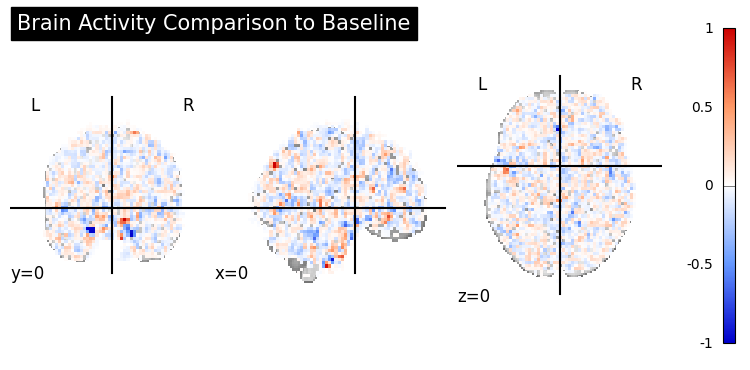

In [22]:
import nibabel as nib
if __name__ == "__main__":
  main1()
  
  # main2()


In [23]:
def mean_check():
  # Load the NIfTI file
  img = nib.load("baseline_mean.nii.gz")
  data = img.get_fdata()
  header = img.header

  # Extract metadata and stats
  shape = data.shape
  voxel_dims = header.get_zooms()
  intensity_range = (np.min(data), np.max(data))
  mean_intensity = np.mean(data)
  std_intensity = np.std(data)
  affine = img.affine

  # Print stats
  print(f"Shape (X, Y, Z): {shape}")
  print(f"Voxel Dimensions (mm): {voxel_dims}")
  print(f"Intensity Range: {intensity_range}")
  print(f"Mean Intensity: {mean_intensity}")
  print(f"Standard Deviation of Intensity: {std_intensity}")
  print(f"Affine Matrix:\n{affine}")